In [151]:
from functools import reduce
import re
import string
import zipfile

import numpy as np
import scipy.sparse as sparse 
from scipy.sparse.linalg import svds
from scipy.sparse import find
from scipy.sparse import csr_matrix
from pandas import read_csv
from nltk.stem.snowball import SnowballStemmer
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.extmath import randomized_svd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class StemmerWrapper:
    """ Class wrapper to some language stemmer; Via wrapping, I think,
        it is comfortable to operate with stemmer and functions,
        that formats text for systems.
    """
    def __init__(self, lang="russian"):
        """
        :param lang: Initializing stemmer with setting `lang` language
        """
        self.stemmer = SnowballStemmer(lang)

    def stem(self, *args, **kwargs):
        """ just for beauty and comfortable call"""
        return self.stemmer.stem(*args, **kwargs)

    @staticmethod
    def clean_string(sample_s: str) -> str:
        """
        :param sample_s: string to be formatted
        :return: formatted string
        formats given string by removing unnecessary components for
        building recommendation systems
        """
        # string to lowercase
        sample_s = sample_s.strip().lower()
        # removing one-symbol words
        sample_s = re.sub(r'\b[ЁёА-я]{1}\b', '', sample_s)
        # removing punctuation
        sample_s = re.sub(r'[%s]' % re.escape(string.punctuation), ' ',
                          sample_s)
        # removing one-digit numbers
        sample_s = re.sub(r'\b[0-9]{1}\b', '', sample_s)
        # replacing several-in-a-row space symbols with only one space
        sample_s = re.sub(r'\s+', ' ', sample_s)
        return sample_s.strip()


In [3]:
class Loader:
    """
    Class represents data-loader for systems. This is a base-class,
    so some virtual function must be overwritten.
    """
    def __init__(self, stemmer):
        """
        :param stemmer: language stemmer to be used
        """
        self.stemmer = stemmer

    def merge_contents(self,
                       table: str,
                       main_id: str,
                       content_cname: str,
                       columns: list):
        """
        merges content of selected `columns` from `table`;
        check overwritten function for more info.
        """
        pass

    @staticmethod
    def split_series(series):
        """
        :return: (pd.core.series.Series) updated `series`-copy
        :param series: (pd.core.series.Series)
        Splitting values in cell's of column `series` (in-place)
        """
        # handling None values separately
        return series.apply(lambda x: x.split() if type(x) == str else [])

    def format_columns(self,
                       dataframe,
                       main_id_cname: str,
                       content_cname: str,
                       columns: list):
        """
        :param dataframe: contains data to be formatted and used
        :param main_id_cname: item-representing-column's name
        :param content_cname: content-representing-column's name
        :param columns: names of columns in dataframe
        :return: 2-column dataframe, named as main_id_cname and
            content_cname; second columns contains formatted
            and merged `columns` content
        """
        # initializing new column in dataframe with empty strings
        dataframe[content_cname] = ''

        # remember items-id-representing column
        id_series = dataframe[main_id_cname]

        # set dataframe to a `columns`-containing table,
        # where all string infos was split into lists
        dataframe = dataframe[[content_cname] + columns].apply(
                self.split_series)

        # formatting all rows
        # firstly, we put add all lists to content containing column
        dataframe[content_cname] = reduce(
                lambda prev, el: prev + dataframe[el],
                columns,
                dataframe[content_cname]
        ).apply(  # then we would stem all words in this column
                lambda iterable: [self.stemmer.stem(w) for w in iterable]
        ).apply(  # lastly, we join lists to string
                lambda iterable: ' '.join(iterable)
        ).apply(
                StemmerWrapper.clean_string
        )

        # set item-representing-column's data
        dataframe[main_id_cname] = id_series

        # return table representing relationship item
        return dataframe[[main_id_cname, content_cname]]

    def parse(self, table: str, columns: list):
        """
        parses selected `columns` from `table`;
        check overwritten function for more info.
        """
        pass


In [4]:
class CsvLoader(Loader):
    """
    Represents data-loader from csv-file
    """
    def __init__(self, stemmer):
        """
        :param stemmer: language stemmer to be used
        """
        super().__init__(stemmer)

    def merge_contents(self,
                       path: str,
                       main_id_cname: str,
                       content_cname: str,
                       columns: list):
        """
        :param path: (str) path to table, where from data will be read
        :param main_id_cname: (str) item-representing-column's name;
            it is explicit for `path` to have such column
        :param content_cname: (str) content-representing-column's name
        :param columns: (list) columns containing main content,
            that will be used to build a content-based model
        :return: (pd.core.frame.DataFrame) 2-column dataframe
            representing relationship of item and it's content
            (one-to-one relationship)
        """
        return self.format_columns(
                self.parse(path, columns + [main_id_cname]),
                main_id_cname,
                content_cname,
                columns
        )

    def parse(self, table: str, columns: list):
        """
        :param table: database table name
        :param columns: columns to be parsed
        :return: dataframe with parsed columns
        """
        return read_csv(
                table,
                skipinitialspace=True,
                usecols=columns
        )


In [5]:
class RecommendationSystem:
    """
    Root-class representing recommendation system
    """
    def __init__(self):
        pass

    def load_and_build(self, *args):
        pass

    def load(self, *args):
        pass

    def build(self, *args):
        pass


In [6]:
class CollaborativeFiltering(RecommendationSystem):
    """
    TODO checkout and comment this class
    Represents recommendation system based on collaborative-filtering
    """
    def __init__(self):
        super(CollaborativeFiltering, self).__init__()
        # sparse matrix of implicit user-item interactions
        self.sparse_matrix = None
        # users matrix in lower rank
        self.users_matrix = None
        # items matrix in lower rank
        self.items_matrix = None

        # dataframes, so we could map indices used in class
        # methods with indices used in database
        self.user_indices_decode = None
        self.item_indices_decode = None

        # column names in database corresponding to user and item
        self.user_cname = None
        self.item_cname = None

    def load(self,
             table: str,
             columns: list,
             loader_type: str = "csv",
             connection=None):
        if len(columns) < 2 or len(columns) > 3:
            raise RuntimeError("CollaborativeFiltering::load: columns "
                               "argument must contain exactly 3 "
                               "string-values")

        # initialize loader
        if loader_type == "csv":
            loader = CsvLoader(None)
        elif loader_type == "db":
            if connection is None:
                raise RuntimeError("CollaborativeFiltering::load: received "
                                   "connection equals to None with a "
                                   "loader_type equals db")
            loader = DataBaseLoader(None, connection)
        else:
            raise RuntimeError("CollaborativeFiltering::load: no loader "
                               "available for given loader_type")

        # load implicit data in 3-column dataframe
        dataframe = loader.parse(table, columns)
        dataframe.dropna(inplace=True)
        
        relations_count = dataframe.shape[0]
        # copying column names explicitly
        self.user_cname, self.item_cname = columns[0] + "", columns[1] + ""
        user_id_cname, item_id_cname = columns[0] + "_id", columns[1] + "_id"

        # save user and item columns, so we will be able to return to
        # caller recommendation as it is stored in database
        dataframe[user_id_cname] = dataframe[columns[0]].astype(
                "category").cat.codes
        dataframe[item_id_cname] = dataframe[columns[1]].astype(
                "category").cat.codes
        self.user_indices_decode = dataframe[
            [user_id_cname, columns[0]]].drop_duplicates()
        self.item_indices_decode = dataframe[
            [item_id_cname, columns[1]]].drop_duplicates()
        dataframe.drop(columns[:2], axis=1, inplace=True)

        # initializing sparse matrix
        users = dataframe[user_id_cname].astype(int)
        items = dataframe[item_id_cname].astype(int)
        users_count = len(dataframe[user_id_cname].unique())
        items_count = len(dataframe[item_id_cname].unique())
        if len(columns) == 3:
            self.sparse_matrix = sparse.csr_matrix(
                    (dataframe[columns[2]], (users, items)),
                    shape=(users_count, items_count)
            )
        elif len(columns) == 2:
            self.sparse_matrix = sparse.csr_matrix(
                    ([1 for _ in range(relations_count)], (users, items)),
                    shape=(users_count, items_count)
            )

    def item2index(self,
                   item):
        """
        :param item: item as it is stored in database
        :return: index used in this object for `item`
        """
        return self.item_indices_decode[
            self.item_cname + "_id"
            ].loc[self.item_indices_decode[self.item_cname] == item].iloc[0]

    def user2index(self,
                   user):
        """
        :param user: user as it is stored in database
        :return: index used in this object for `user`
        """
        return self.user_indices_decode[
            self.user_cname + "_id"
            ].loc[self.user_indices_decode[self.user_cname] == user].iloc[0]

    def index2item(self,
                   items_ids: list):
        """
        :param items_ids: list of indices as they are stored in this
            object
        :return: corresponding to `indices` values of items
        """
        result = list()
        for item_id in items_ids:
            result.append(
                    self.item_indices_decode[
                        self.item_cname
                    ].loc[
                        self.item_indices_decode[
                            self.item_cname + "_id"] == item_id
                        ].iloc[0]
            )
        return result


In [137]:
class ImplicitRS(CollaborativeFiltering):
    """
        Implementing collaborative-filtering recommendation system
        on implicit data of user-item interactions.

        Used algorithm: Implicit-ALS via Conjugate Gradient Method
        (in each step, vector is minimized along a search direction)

        Used materials:
        - http://www.sze.hu/~gtakacs/download/recsys_2011_draft.pdf
        - http://www.yifanhu.net/PUB/cf.pdf

        Briefly, implicit data is going to be gathered by user's
        behaviour on exact product. If he will visit product site-page,
        we will assume, that he is interested in such kind of products
        and will look for other users with similar interests to
        make a recommendation. Otherwise, we will assume, that we
        know nothing about users opinion on product and will construct
        model with a some small positive value for this product.

        In build method, we are asking for `rank`, `iter_count`,
        `lambda_val` and `alpha` parameters.
    """

    def __init__(self):
        super(ImplicitRS, self).__init__()
        # users matrix in lower rank
        self.users_matrix = None
        # items matrix in lower rank
        self.items_matrix = None
        # recsys builted matrix
        self.recommendations = None

        # projecting [min, max) on range [0, 1) # not sure about
        # boundary points
        self.min_max_scaler = MinMaxScaler()

        # use to save memory resources from lots of data possibly
        # never been recommended
        self.fast_reqs_limit = -1

    def set_limit(self, value: int = 100):
        """
        :param value: new value to be set
        """
        self.fast_reqs_limit = value

    def build(self,
              rank=20,
              iter_count=25,
              lambda_val=0.1,
              alpha=40):
        """
        :param rank: (int) aim-rank to user and item representing
            matrices. We want A ~ U @ V,  where A (m x n) is our
            sparse matrix of interactions, matrix U (m x rank)
            represents users and matrix V (n x rank) represents items.
        :param iter_count: (int) iterations count to build matrix
        :param lambda_val: (double) parameter used in algo...
        :param alpha: (double) parameter representing how strongly
            we will be confident about the fact of interaction
            between user and item
        """
        self.__implicit_als(rank, iter_count, lambda_val, alpha)
        # other possible variants:
        # 1. recs = np.argsort(-users_matrix @ items_matrix.T, axis=1)
        # 2. qr(items_matrix)
        #    recs = np.argsort(-users_matrix @ q.T, axis=1)
        # all of them show quite equal results
        q, r = np.linalg.qr(self.items_matrix)
        self.recommendations = np.argsort(
                -(self.sparse_matrix @ q) @ q.T,
                axis=1
        )[:, :self.fast_reqs_limit]

    @staticmethod
    def _non_zeros_in_row(csr_matrix,
                          row):
        """
        :param csr_matrix: sparse matrix
        :param row: row of sparse matrix
        :return: range of tuples of 2 elements: index of column of
            non-zero element in csr_matrix's row and value of non-zero
            element itself
        """
        for i in range(csr_matrix.indptr[row], csr_matrix.indptr[row + 1]):
            yield csr_matrix.indices[i], csr_matrix.data[i]

    def __wrr(self,
              init_vec,
              a_mat,
              r_vec,
              c_mat,
              item_mat,
              u_id: int,
              iter_count: int):
        """
        Weighted Ridge Regression.
        I accepted M (from algorithm) equals to identity matrix.
        To understand what is going on in code below, take a look to
        one of those two links in class declaration docstring above.
        :param init_vec: vector w with which we are currently
            working; we are minimizing with respect to this vector.
        :param a_mat: matrix A from algorithm.
        :param r_vec: difference between Aw and b.
        :param c_mat: matrix representing confidence.
        :param item_mat: matrix of items.
        :param u_id: user's id of one whose vector we are formatting.
        :param iter_count: count of iterations to be done.
        :return: preconditioned conjugate gradient method for
            solving Aw = b.
        """
        p_vec = r_vec.copy()
        gamma = r_vec.dot(r_vec)  # gamma = r^T z, where z = M^1 r
        for _ in range(iter_count):
            # find A
            a_dot_p = a_mat @ p_vec
            for it_id, conf in self._non_zeros_in_row(c_mat, u_id):
                a_dot_p += (conf - 1) * (
                        item_mat[it_id] @ p_vec) * item_mat[it_id]

            # updating w and r vectors
            alpha = gamma / (p_vec @ a_dot_p)
            init_vec += alpha * p_vec
            r_vec -= alpha * a_dot_p

            # below: p = z + beta p, beta = gamma / (r^T z)
            tmp_gamma = r_vec.dot(r_vec)
            p_vec = r_vec + (gamma / tmp_gamma) * p_vec
            gamma = tmp_gamma
        return init_vec

    def __least_squares(self,
                        c_mat,
                        user_mat,
                        item_mat,
                        lambda_val,
                        iter_count=5):
        """
        We will to solve next equations for each u (user) and v (item):
        (U.T @ U + lambda * I + U.T @ (C_v - I) @ U) @ v
            = U.T @ C_v * interacted(v)
        (V.T @ V + lambda * I + V.T @ (C_u - I) @ V) @ u
            = V.T @ C_u * interacted(u)
        with a conjugate gradient method, where
        A = U.T @ U + lambda * I + U.T @ (C_v - I) @ U,
        b = U.T @ C_v * interacted(v)
        :param c_mat: mat represents confidence about u-i interactions
            (by our definition, confidence_{ui} = 1 + alpha r_{ui})
        :param user_mat: matrix of size m x rank, represents users
        :param item_mat: matrix of size n x rank, represents items
        :param lambda_val: non-negative regularization coefficient
        :param iter_count: count of iterations to be done
        """
        users_count, rank = user_mat.shape

        # matrix of size (r, r)
        a_mat = item_mat.T @ item_mat + lambda_val * np.eye(rank)

        for u_id in range(users_count):
            # vector of size (r, )
            w = user_mat[u_id]

            # find r = b − Aw, vector of size (r, )
            r_vec = -a_mat @ w
            for it_id, conf in self._non_zeros_in_row(c_mat, u_id):
                r_vec += (conf - (conf - 1) *
                          (item_mat[it_id] @ w)) * item_mat[it_id]

            # applying __wrr to user_mat[u_id]
            user_mat[u_id] = self.__wrr(
                    w, a_mat, r_vec, c_mat, item_mat, u_id, iter_count
            )

    def __implicit_als(self,
                       rank,
                       iter_count,
                       lambda_val,
                       alpha):
        """
        here are used same params as in method `build`
        """
        # formatting confidences matrix
        c_user_item = (self.sparse_matrix * alpha).astype('double').tocsr()
        c_item_user = c_user_item.T.tocsr()

        # initializing user and item representing matrices
        user_size, item_size = self.sparse_matrix.shape
        # zero-matrices consume more time, so rands are better
        user = np.random.rand(user_size, rank) * 0.01
        item = np.random.rand(item_size, rank) * 0.01

        # algo itself
        for _ in range(iter_count):
            self.__least_squares(c_user_item, user, item, lambda_val)
            self.__least_squares(c_item_user, item, user, lambda_val)

        # defining object's attributes
        self.users_matrix, self.items_matrix = user, item

    def find_similar_item(self,
                          item,
                          res_n: int = 10):
        """
        :param item: item as it is stored in database
            (meant it is in column that was given to load)
        :param res_n: count of items to find
        :return: `res_n` most similar to `item` items
        """
        item_id = self.item2index(item)
        # get vector corresponding to item
        item_vec = self.items_matrix[item_id].T
        # multiply item_vec to items_matrix,
        # so we will just sort scalar products of vectors
        scores = self.items_matrix.dot(item_vec).reshape(1, -1)[0]
        # choose top `res_n` and return them
        return self.index2item(np.argsort(scores)[::-1][:res_n])

    def recommend_to_user(self,
                          user,
                          res_n: int = 10):
        """
        :param user: user as it is stored in database
            (meant it is in column that was given to load)
        :param res_n: count of items to recommend
        :return: `res_n` most suitable (by RS) items for `user`
        """
        user_id = self.user2index(user)

        # to not recommend items user has consumed/interacted
        user_interactions = self.sparse_matrix[user_id, :].toarray()
        user_interactions = user_interactions.reshape(-1) + 1
        user_interactions[user_interactions > 1] = 0

        # calculate the recommendation by taking the product
        # of user vector with the item vectors
        rec_vector = (self.users_matrix[user_id, :] @
                      self.items_matrix.T)

        # scaling scores to make them easier to interpret
        rec_vector_scaled = self.min_max_scaler.fit_transform(
                rec_vector.reshape(-1, 1)
        )[:, 0]

        # do not multiply, if want consumed items to be recommended too
        recommend_vector = user_interactions * rec_vector_scaled

        # choose top `res_n` and return them
        return self.index2item(np.argsort(recommend_vector)[::-1][:res_n])

    def fast_recommend(self,
                       user,
                       res_n: int = 10):
        """
            :param user: user as it is stored in database
                (meant it is in column that was given to load)
            :param res_n: count of items to recommend
            :return: `res_n` most suitable (by RS) items for `user`
        """
        user_id = self.user2index(user)
        rec_vector = self.recommendations[user_id, :]
        return self.index2item(rec_vector[:res_n])

    def drop_slow(self):
        del self.sparse_matrix
        del self.users_matrix
        del self.items_matrix
        del self.min_max_scaler


Посмотрим как отрабатывает модель на небольшом сете данных. Для начала загрузим данные и построим модель.

In [139]:
implicit_rec = ImplicitRS()
print("loading started...")
implicit_rec.load("small_data/lastfm2collab.csv", ["user_id", "item_id"])
print("loading finished...")
implicit_rec.set_limit()
print("building started...")
implicit_rec.build()
print("building finished...")


[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [ ]:
n, m = implicit_rec.sparse_matrix.shape
print("user x items:\t", n, "x", m)


Методы, которые строят рекомендации в рантайме.

In [ ]:
q_item = "linkin park"
similar_items = implicit_rec.find_similar_item(q_item)
print("similar items:", *similar_items, sep="\n")

q_user = 5985
user_recs = implicit_rec.recommend_to_user(q_user)
print("\nusers recs:", *user_recs, sep="\n")


Метод, который строит рекомендации по заранее построенной модели.

In [ ]:
implicit_rec.drop_slow()
user_fast_recs = implicit_rec.fast_recommend(q_user)
print("\nusers fast recs:", *user_fast_recs, sep="\n")


Теперь посмотрим на поведеление нашей рекомендательной системы на большем объеме данных. Для начала подгрузим данные

In [10]:
user_ids = []
movie_ids = []
ratings = []
with zipfile.ZipFile('data/ml-10m.zip') as archive:
    with archive.open('ml-10M100K/ratings.dat') as f:
        for l in f:
            user, movie, rating, _ = l.split(b'::')
            user_ids.append(int(user) - 1)
            movie_ids.append(int(movie) - 1)
            ratings.append(float(rating))

Формируем sparse-матрицу всех данных и разбиваем ее на тестовый и обучающий сеты. Для начала попробуем оценить успех по бинарным данным.

In [11]:
A = csr_matrix((np.array(ratings) >= 4, (user_ids, movie_ids)), dtype=np.float32)
A.eliminate_zeros()
print("Shape:", A.shape)
print("Ratio of nonzero elements:", A.nnz / (A.shape[0] * A.shape[1]))

Shape: (71567, 65133)
Ratio of nonzero elements: 0.0010738646228571796


In [12]:
n_users, n_movies = A.shape
n_test = int(n_users * 0.2)
n_train = n_users - n_test
idx = np.arange(n_users)
np.random.shuffle(idx)
test_idx, train_idx = idx[:n_test], idx[n_test:]
A_test, A_train = A[test_idx,:], A[train_idx,:]

Напишем функции для оценки качества предсказаний, которые повторяют поведение наших методов (в частности, "быстрого").

In [72]:
def recommend(score_mat, pred_am, V):
    """
        Input
            score_mat: sparse batch_size x n_movies array
            pred_am: requested number of recommendations
            V: 2D numpy array (n_movies x rank)
            
        Output
            recs: batch_size x pred_am array of movies to recommend, with descending predicted rating
    """
    Q, R = np.linalg.qr(V)
    mat_recs = (score_mat @ Q) @ Q.T
    recs = np.argsort(-mat_recs, axis=1)[:, :pred_am]
    return recs

In [66]:
def evaluate_model(A_test, pred_am, V, batch_size=500):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users
            pred_am: requested number of recommendations
            V: 2D numpy array representing the rating model
            batch_size: number of users to build recommendations for in a single call to recommend

        Output
            hit_idx: list of n_test ints: place of secret movie 
                     in top-pred_am recommendations (or pred_am if it is missing)
    """
    secrets = []
    nonempty_users = []
    A_test = A_test.copy()
    for user in range(A_test.shape[0]):
        _, good, _ = find(A_test[user,:])
        if len(good) == 0:
            continue
        nonempty_users.append(user)
        secret = np.random.choice(good, 1)[0]
        A_test[user, secret] = 0
        secrets.append(secret)
    hit_idx = []
    for i in range(0, len(nonempty_users), batch_size):
        # Build recomendations for a batch.
        recommendations = recommend(A_test[nonempty_users[i:i + batch_size], :], pred_am + 1, V)
        # Place secret in the last column so that the following .argmax finds it.
        recommendations[:,-1] = secrets[i: i + batch_size]
        # Find secret among the recommendations and place its index into batch_hit_idx.
        batch_hit_idx = (recommendations == np.array([secrets[i:i + batch_size]]).T).argmax(1)
        hit_idx += batch_hit_idx.tolist()
    return hit_idx

In [67]:
def get_hit_rates(A_test, pred_ams, V):
    """
        Input
            A_test: sparse n_test x n_movies array corresponding to new users 
            pred_ams: list of ints: number of top recomendations to evaluate hit rate for
            V: 2D numpy array representing the rating model
        Output
            hit_rates: list of float: hit rate for each element of n_recs
    """
    hit_idx = evaluate_model(A_test, max(pred_ams), V)
    hit_rates = []
    for pred_am in pred_ams:
        hit_rates.append(sum(map(lambda x: int(x < pred_am), hit_idx)) / len(hit_idx))
    return hit_rates

Посмотрим для уверенности, как они отрабавают на SVD разложении.

In [68]:
rank = 30
_, _, VT_svd = svds(A_test[:1000, :], k=rank)
print(f"hitrate of top-10 over SVD(k=30):\t{get_hit_rates(A_test[:1000, :], [10], VT_svd.T)[0] * 100}%")
print(f"hitrate of top-10 over SVD(k=30):\t{get_hit_rates(A_test[:1000, :], [10], VT_svd.T)[0] * 100}%")
print(f"hitrate of top-10 over SVD(k=30):\t{get_hit_rates(A_test[:1000, :], [10], VT_svd.T)[0] * 100}%")

hitrate of top-10 over SVD(k=30):	12.345679012345679%
hitrate of top-10 over SVD(k=30):	12.037037037037036%
hitrate of top-10 over SVD(k=30):	11.213991769547325%


Функции, повторяющие поведение наших методов.

In [83]:
def non_zeros_in_row(csr_matrix,
                     row):
    """
    :param csr_matrix: sparse matrix
    :param row: row of sparse matrix
    :return: range of tuples of 2 elements: index of column of
        non-zero element in csr_matrix's row and value of non-zero
        element itself
    """
    for i in range(csr_matrix.indptr[row], csr_matrix.indptr[row + 1]):
        yield csr_matrix.indices[i], csr_matrix.data[i]


In [ ]:
def wrr(init_vec,
        a_mat,
        r_vec,
        c_mat,
        item_mat,
        u_id: int,
        iter_count: int):
    """
    Weighted Ridge Regression.
    I accepted M (from algorithm) equals to identity matrix.
    To understand what is going on in code below, take a look to
    one of those two links in class declaration docstring above.
    :param init_vec: vector w with which we are currently
        working; we are minimizing with respect to this vector.
    :param a_mat: matrix A from algorithm.
    :param r_vec: difference between Aw and b.
    :param c_mat: matrix representing confidence.
    :param item_mat: matrix of items.
    :param u_id: user's id of one whose vector we are formatting.
    :param iter_count: count of iterations to be done.
    :return: preconditioned conjugate gradient method for
        solving Aw = b.
    """
    p_vec = r_vec.copy()
    gamma = r_vec.dot(r_vec)  # gamma = r^T z, where z = M^1 r
    for _ in range(iter_count):
        # find A
        a_dot_p = a_mat @ p_vec
        for it_id, conf in non_zeros_in_row(c_mat, u_id):
            # TODO try without minus 1
            a_dot_p += (conf - 1) * (
                    item_mat[it_id] @ p_vec) * item_mat[it_id]

        # updating w and r vectors
        alpha = gamma / (p_vec @ a_dot_p)
        init_vec += alpha * p_vec
        r_vec -= alpha * a_dot_p

        # below: p = z + beta p, beta = gamma / (r^T z)
        tmp_gamma = r_vec.dot(r_vec)
        p_vec = r_vec + (gamma / tmp_gamma) * p_vec
        gamma = tmp_gamma
    return init_vec


In [ ]:
def least_squares(c_mat,
                  user_mat,
                  item_mat,
                  lambda_val,
                  iter_count=5):
    """
    TODO try without UTU and VTV
    We will to solve next equations for each u (user) and v (item):
    (U.T @ U + lambda * I + U.T @ (C_v - I) @ U) @ v
        = U.T @ C_v * interacted(v)
    (V.T @ V + lambda * I + V.T @ (C_u - I) @ V) @ u
        = V.T @ C_u * interacted(u)
    with a conjugate gradient method, where
    A = U.T @ U + lambda * I + U.T @ (C_v - I) @ U,
    b = U.T @ C_v * interacted(v)
    
    r = X.T @ C_y * interacted(y) - (X.T @ X + lambda * I) @ y - X.T @ (C_y - I) @ X @ y 
    r = X.T @ (C_y - (C_y - I) @ X @ y) * interacted(y) - (X.T @ X + lambda * I) @ y 
    
    :param c_mat: mat represents confidence about u-i interactions
        (by our definition, confidence_{ui} = 1 + alpha r_{ui})
    :param user_mat: matrix of size m x rank, represents users
    :param item_mat: matrix of size n x rank, represents items
    :param lambda_val: non-negative regularization coefficient
    :param iter_count: count of iterations to be done
    :return:
    """
    users_count, rank = user_mat.shape

    # matrix of size (r, r)
    a_mat = item_mat.T @ item_mat + lambda_val * np.eye(rank)

    for u_id in range(users_count):
        # vector of size (r, )
        w = user_mat[u_id]

        # find r = b − Aw, vector of size (r, )
        r_vec = -a_mat @ w
        for it_id, conf in non_zeros_in_row(c_mat, u_id):
            # TODO try without minus 1
            r_vec += (conf - (conf - 1) *
                      (item_mat[it_id] @ w)) * item_mat[it_id]

        # applying wrr to user_mat[u_id]
        user_mat[u_id] = wrr(
                w, a_mat, r_vec, c_mat, item_mat, u_id, iter_count
        )


In [149]:
def implicit_als(sparse_matrix,
                 rank=20,
                 iter_count=10,
                 lambda_val=0.1,
                 alpha=40):
    """
    here are used same params as in method `build`
    """
    # TRIED with + I: RESULT lower hitrate

    # formatting confidences matrix
    c_user_item = (sparse_matrix * alpha).astype('double').tocsr()
    c_item_user = c_user_item.T.tocsr()

    # initializing user and item representing matrices
    user_size, item_size = sparse_matrix.shape
    user = np.random.rand(user_size, rank) * 0.01  # TRIED zero matrices
    item = np.random.rand(item_size, rank) * 0.01  # RESULT more time consumed

    # algo itself
    for i in range(iter_count):
        print(i, end=' ')
        least_squares(c_user_item, user, item, lambda_val)
        least_squares(c_item_user, item, user, lambda_val)
    print()
    # defining object's attributes
    return user, item


Хитрейты нашего алгоритма iALS на матрице размера 1000 х 65133 c рангом 25 и количеством итераций 20.

In [89]:
rank = 30
_, V_als = implicit_als(A_test[:1000, :])
print(f"shape: 1000 x {A_test.shape[1]}")
print(f"hitrate of top-10 over iALS(k=20):\t{get_hit_rates(A_test[:1000, :], [10], V_ials)[0] * 100}%")
print(f"hitrate of top-10 over iALS(k=20):\t{get_hit_rates(A_test[:1000, :], [10], V_ials)[0] * 100}%")
print(f"hitrate of top-10 over iALS(k=20):\t{get_hit_rates(A_test[:1000, :], [10], V_ials)[0] * 100}%")


(65133, 20)
(65133, 20)
hitrate of top-10 over iALS(k=20):	12.037037037037036%
(65133, 20)
(65133, 20)
hitrate of top-10 over iALS(k=20):	11.419753086419753%
(65133, 20)
(65133, 20)
hitrate of top-10 over iALS(k=20):	12.551440329218108%


In [85]:
%timeit -r 3 -n 3 _, V_ials = implicit_als(A_test[:1000, :], rank=25, iter_count=20)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 
2min 34s ± 486 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)


0 1 2 3 4 5 6 7 8 9 


C:\programming\anaconda\lib\site-packages\sklearn\utils\extmath.py:368: FutureWarning: If 'random_state' is not supplied, the current default is to use 0 as a fixed seed. This will change to  None in version 1.2 leading to non-deterministic results that better reflect nature of the randomized_svd solver. If you want to silence this warning, set 'random_state' to an integer seed or to None explicitly depending if you want your code to be deterministic or not.
  warnings.warn(


(65133, 5)
(65133, 5)
(65133, 5)
(65133, 5)
(65133, 5)
(65133, 5)
0 1 2 3 4 5 6 7 8 9 
(65133, 25)
(65133, 25)
(65133, 25)
(65133, 25)
(65133, 25)
(65133, 25)
0 1 2 3 4 5 6 7 8 9 
(65133, 50)
(65133, 50)
(65133, 50)
(65133, 50)
(65133, 50)
(65133, 50)


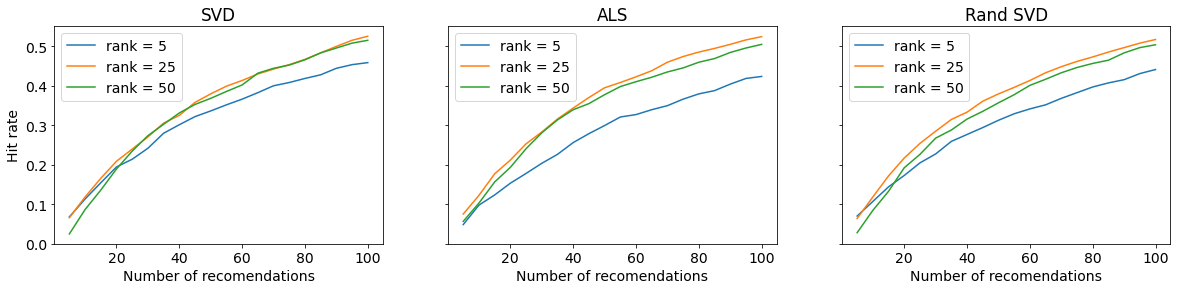

In [152]:
pred_ams = list(range(5, 101, 5))

plt.rcParams.update({'font.size': 14})
_, (ax_svd, ax_als, ax_rand) = plt.subplots(1,3,figsize=(20, 4),sharey=True)

ax_svd.set_title("SVD")
ax_svd.set_ylabel("Hit rate")
ax_als.set_title("ALS")
ax_rand.set_title("Rand SVD")
for rank in [5, 25, 50]:
    _, _, VT_svd = svds(A_train[:5000, :], k=rank)
    _, V_als = implicit_als(A_train[:5000, :], rank)
    _, _, VT_rand = randomized_svd(A_train[:5000, :], rank)
    for V, ax in zip([VT_svd.T, V_als, VT_rand.T], [ax_svd, ax_als, ax_rand]):
        ax.set_xlabel("Number of recomendations")
        hit_rates = get_hit_rates(A_test[:1000,:], pred_ams, V)
        line, = ax.plot(pred_ams, hit_rates)
        line.set_label('rank = {}'.format(rank))
        ax.legend()
